# Evaluacija modela i analiza rezultata

In [31]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from datasets import load_from_disk
from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd


In [2]:
test_dataset = load_from_disk("tokenized/test")
small_test_dataset = test_dataset.select(range(1000))

In [3]:
model_path = "/Users/milica/Desktop/Web Mining/traning/distilroberta-base-sst2/distilroberta-base-sst2-distilled"
model_path2 = "/Users/milica/Desktop/Web Mining/traning/distilroberta/distilroberta-base"
model_path3 = "//Users/milica/Desktop/Web Mining/traning/twitter-roberta/twitter-roberta-base-sentiment"
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model_distil_sst2 = RobertaForSequenceClassification.from_pretrained(model_path)
model_distil_base = RobertaForSequenceClassification.from_pretrained(model_path2)
model_twitter = RobertaForSequenceClassification.from_pretrained(model_path3)

In [4]:
def evaluate_model(trainer, dataset):
    preds = trainer.predict(dataset)
    y_true = preds.label_ids
    y_pred = preds.predictions.argmax(axis=-1)

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)

    return {
        "y_true": y_true,
        "y_pred": y_pred,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm
    }


In [5]:
args1 = TrainingArguments(
    output_dir="./tmp_eval1",
    per_device_eval_batch_size=16
)
args2 = TrainingArguments(
    output_dir="./tmp_eval2",
    per_device_eval_batch_size=16
)
args3 = TrainingArguments(
    output_dir="./tmp_eval3",
    per_device_eval_batch_size=16
)

# 3. napravi Trainer
trainer_distil_sst2 = Trainer(
    model=model_distil_sst2,
    args=args1,
    tokenizer=tokenizer
)
trainer_distil_base = Trainer(
    model=model_distil_base,
    args=args2,
    tokenizer=tokenizer
)
trainer_twitter = Trainer(
    model=model_twitter,
    args=args3,
    tokenizer=tokenizer
)

/var/folders/yw/kbwfb9gn6y59z9jydmclz48h0000gn/T/ipykernel_27378/3745935811.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_distil_sst2 = Trainer(
/var/folders/yw/kbwfb9gn6y59z9jydmclz48h0000gn/T/ipykernel_27378/3745935811.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_distil_base = Trainer(
/var/folders/yw/kbwfb9gn6y59z9jydmclz48h0000gn/T/ipykernel_27378/3745935811.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_twitter = Trainer(


In [6]:
results_base = evaluate_model(trainer_distil_base, small_test_dataset)
results_distil = evaluate_model(trainer_distil_sst2, small_test_dataset)
results_twitter = evaluate_model(trainer_twitter, small_test_dataset)


## Poređenje performansi modela

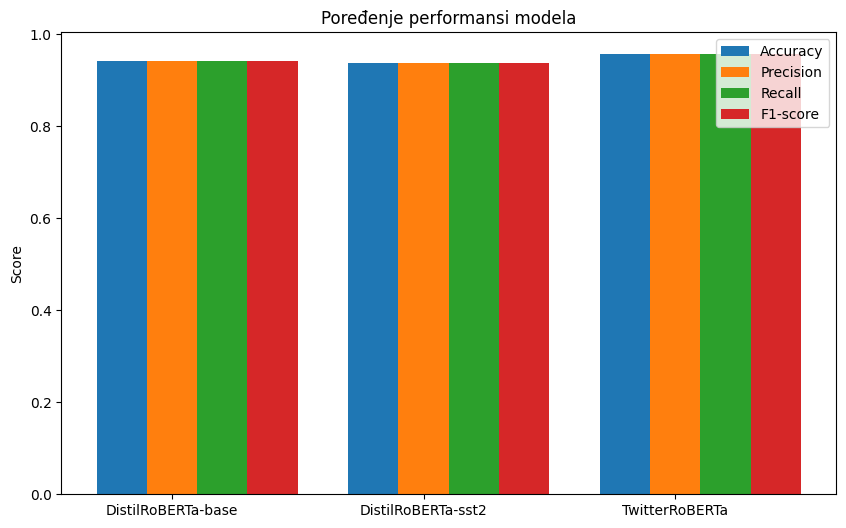

In [ ]:
models = ["DistilRoBERTa-base", "DistilRoBERTa-sst2", "TwitterRoBERTa"]
accuracy = [results_base["accuracy"], results_distil["accuracy"], results_twitter["accuracy"]]
f1 = [results_base["f1"], results_distil["f1"], results_twitter["f1"]]
precision = [results_base["precision"], results_distil["precision"], results_twitter["precision"]]
recall = [results_base["recall"], results_distil["recall"], results_twitter["recall"]]

x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(10,6))
plt.bar(x - width, accuracy, width, label="Accuracy")
plt.bar(x, precision, width, label="Precision")
plt.bar(x + width, recall, width, label="Recall")
plt.bar(x + 2*width, f1, width, label="F1-score")

plt.xticks(x, models)
plt.ylabel("Score")
plt.title("Poređenje performansi modela")
plt.legend()
plt.show()


## Matrice konfuzije modela

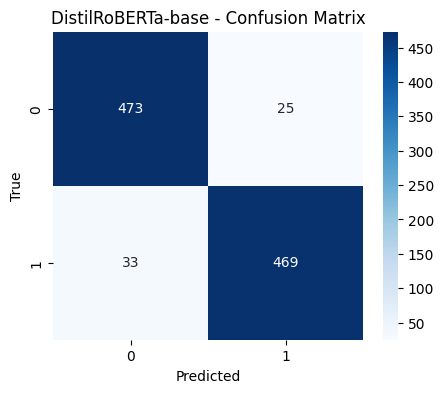

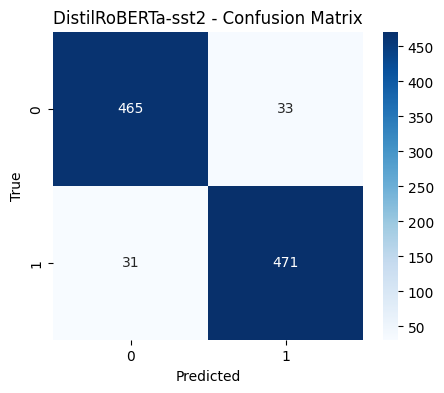

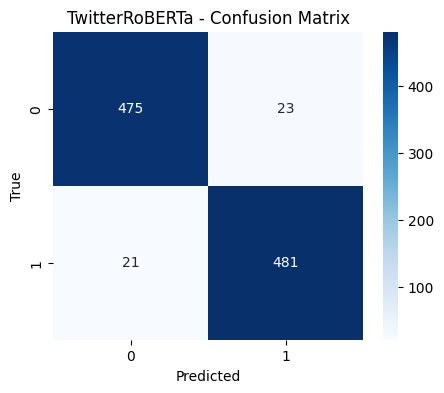

In [ ]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(results_base["confusion_matrix"], "DistilRoBERTa-base - Confusion Matrix")
plot_confusion_matrix(results_distil["confusion_matrix"], "DistilRoBERTa-sst2 - Confusion Matrix")
plot_confusion_matrix(results_twitter["confusion_matrix"], "TwitterRoBERTa - Confusion Matrix")

## ROC krive

In [ ]:
def plot_roc_curve(y_true, y_pred_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = roc_auc_score(y_true, y_pred_prob)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.show()


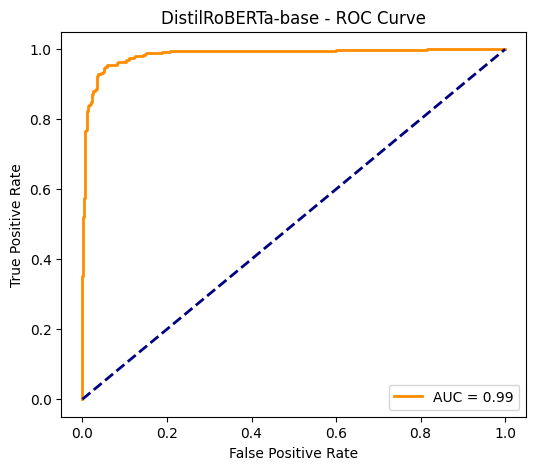

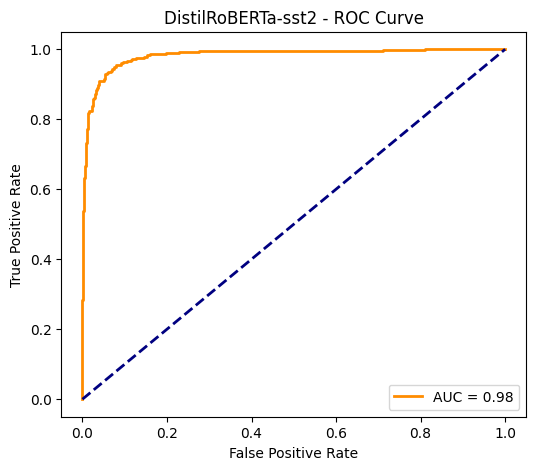

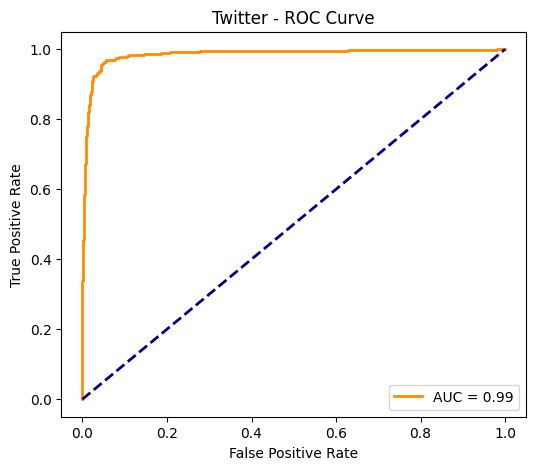

In [10]:
preds_base = trainer_distil_base.predict(small_test_dataset).predictions
preds_distil = trainer_distil_sst2.predict(small_test_dataset).predictions
preds_twitter = trainer_twitter.predict(small_test_dataset).predictions

plot_roc_curve(results_base["y_true"], preds_base[:, 1], "DistilRoBERTa-base - ROC Curve")
plot_roc_curve(results_distil["y_true"], preds_distil[:, 1], "DistilRoBERTa-sst2 - ROC Curve")
plot_roc_curve(results_twitter["y_true"], preds_twitter[:, 1], "Twitter - ROC Curve")


## Distribucija predikcije po klasama

In [11]:
preds_base = trainer_distil_base.predict(small_test_dataset)
y_pred_base = np.argmax(preds_base.predictions, axis=1)

preds_sst2 = trainer_distil_sst2.predict(small_test_dataset)
y_pred_sst2 = np.argmax(preds_sst2.predictions, axis=1)

preds_twitter = trainer_twitter.predict(small_test_dataset)
y_pred_twitter = np.argmax(preds_twitter.predictions, axis=1)

print(np.unique(y_pred_base))
print(np.unique(y_pred_sst2))
print(np.unique(y_pred_twitter))


[0 1]
[0 1]
[0 1]


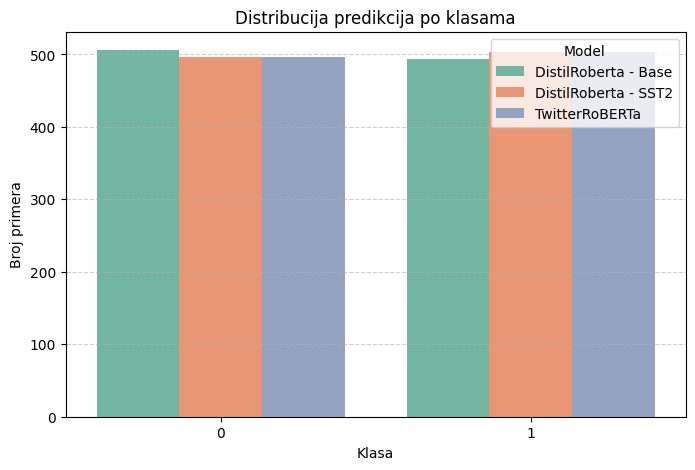

In [14]:
df_plot = pd.DataFrame({
    "DistilRoberta - Base": y_pred_base.astype(int),
    "DistilRoberta - SST2": y_pred_sst2.astype(int),
    "TwitterRoBERTa": y_pred_twitter.astype(int)
})

df_melt = df_plot.melt(var_name="Model", value_name="Klasa")

plt.figure(figsize=(8,5))
sns.countplot(data=df_melt, x="Klasa", hue="Model", palette="Set2")
plt.title("Distribucija predikcija po klasama")
plt.xlabel("Klasa")
plt.ylabel("Broj primera")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


## Analiza greska

In [16]:
def error_analysis(y_true, y_pred, original_texts):
    errors = []
    for i, (true, pred) in enumerate(zip(y_true, y_pred)):
        if true != pred:
            errors.append({"index": i, "true": true, "pred": pred, "text": original_texts[i]})
    return pd.DataFrame(errors)

test_df = pd.read_csv("data/test_df.csv")
test_df = test_df[:1000]
test_list = test_df["clean_text"].tolist()
errors_base = error_analysis(results_base["y_true"], results_base["y_pred"], test_list)
errors_base.head(10)


,index,true,pred,text
0,63,0,1,historical gem whose title obscures intent sta...
1,71,1,0,recommend ordering size larger regular size or...
2,75,0,1,nice product wife loves unfortunately perchace...
3,81,1,0,would sell book complete dust cover excellent ...
4,88,1,0,creepy creepiest book ive ever read creepy mys...
5,89,0,1,book time hands book great many people give on...
6,94,1,0,scarlet letter much amazement book placed bann...
7,101,1,0,sassy baby warming dish interesting concept tr...
8,103,0,1,used circuits project used generator circuits ...
9,137,0,1,hard find types chargers since mac switched ma...


In [17]:
errors_distil = error_analysis(results_distil["y_true"], results_distil["y_pred"], test_list)
errors_distil.head(10)

,index,true,pred,text
0,18,1,0,soy un apasionado del box este libro est espln...
1,63,0,1,historical gem whose title obscures intent sta...
2,71,1,0,recommend ordering size larger regular size or...
3,75,0,1,nice product wife loves unfortunately perchace...
4,88,1,0,creepy creepiest book ive ever read creepy mys...
5,89,0,1,book time hands book great many people give on...
6,94,1,0,scarlet letter much amazement book placed bann...
7,101,1,0,sassy baby warming dish interesting concept tr...
8,103,0,1,used circuits project used generator circuits ...
9,137,0,1,hard find types chargers since mac switched ma...


In [18]:
errors_twitter = error_analysis(results_twitter["y_true"], results_twitter["y_pred"], test_list)
errors_twitter.head(10)


,index,true,pred,text
0,75,0,1,nice product wife loves unfortunately perchace...
1,81,1,0,would sell book complete dust cover excellent ...
2,89,0,1,book time hands book great many people give on...
3,98,0,1,read read book school like im sure point story...
4,101,1,0,sassy baby warming dish interesting concept tr...
5,103,0,1,used circuits project used generator circuits ...
6,137,0,1,hard find types chargers since mac switched ma...
7,161,1,0,course book well course called fundamnetals so...
8,174,1,0,many issues story interesting action enemies a...
9,179,0,1,good midway point wonderful victorianstyle nov...


In [19]:
errors_base['length'] = errors_base['text'].apply(len)
errors_base.sort_values(by='length', ascending=False).head(10)

,index,true,pred,text,length
13,233,1,0,typical thomas video james biggest problem dvd...,569
44,753,1,0,title revised say advancement homeland securit...,562
15,250,1,0,effective book discussing physical death child...,521
1,71,1,0,recommend ordering size larger regular size or...,518
27,401,0,1,good politics science book starts enticing psy...,485
52,901,0,1,may modernday classic horror film based origin...,468
37,554,1,0,statin levels based researchedread pill formul...,461
35,546,1,0,discontinued another reviewer recently advised...,434
54,947,0,1,coyote genius usual girl goes big city cliches...,402
47,846,1,0,nietzsche antichrist nietzsche fed christianit...,381


In [20]:
errors_distil['length'] = errors_distil['text'].apply(len)
errors_distil.sort_values(by='length', ascending=False).head(10)

,index,true,pred,text,length
38,576,0,1,informative idiosyncratic coverage historical ...,700
13,233,1,0,typical thomas video james biggest problem dvd...,569
16,250,1,0,effective book discussing physical death child...,521
2,71,1,0,recommend ordering size larger regular size or...,518
21,340,0,1,transformers dark moon accounts michael baydir...,502
28,401,0,1,good politics science book starts enticing psy...,485
56,901,0,1,may modernday classic horror film based origin...,468
37,554,1,0,statin levels based researchedread pill formul...,461
35,546,1,0,discontinued another reviewer recently advised...,434
60,947,0,1,coyote genius usual girl goes big city cliches...,402


In [21]:
errors_twitter['length'] = errors_twitter['text'].apply(len)
errors_twitter.sort_values(by='length', ascending=False).head(10)

,index,true,pred,text,length
10,233,1,0,typical thomas video james biggest problem dvd...,569
11,250,1,0,effective book discussing physical death child...,521
21,401,0,1,good politics science book starts enticing psy...,485
37,901,0,1,may modernday classic horror film based origin...,468
27,554,1,0,statin levels based researchedread pill formul...,461
25,546,1,0,discontinued another reviewer recently advised...,434
41,947,0,1,coyote genius usual girl goes big city cliches...,402
33,840,0,1,unusual writing technique joyce quite understa...,381
38,912,1,0,make sure see jean de florette first second pa...,358
16,362,1,0,good idea good looks needs lots work recently ...,348


In [ ]:
errors_base[(errors_base['true'] == 0) & (errors_base['pred'] == 1)].head(10)

,index,true,pred,text,length
0,63,0,1,historical gem whose title obscures intent sta...,349
2,75,0,1,nice product wife loves unfortunately perchace...,253
5,89,0,1,book time hands book great many people give on...,305
8,103,0,1,used circuits project used generator circuits ...,225
9,137,0,1,hard find types chargers since mac switched ma...,127
12,179,0,1,good midway point wonderful victorianstyle nov...,269
24,382,0,1,sounds great sounds great im wondering already...,84
25,395,0,1,curved thomas train tracks good product priced...,78
27,401,0,1,good politics science book starts enticing psy...,485
28,405,0,1,tough going got pretty bogged multiple charact...,137


In [ ]:
errors_distil[(errors_distil['true'] == 0) & (errors_distil['pred'] == 1)].head(10)

,index,true,pred,text,length
1,63,0,1,historical gem whose title obscures intent sta...,349
3,75,0,1,nice product wife loves unfortunately perchace...,253
5,89,0,1,book time hands book great many people give on...,305
8,103,0,1,used circuits project used generator circuits ...,225
9,137,0,1,hard find types chargers since mac switched ma...,127
12,179,0,1,good midway point wonderful victorianstyle nov...,269
19,307,0,1,ummm using several months particularly impress...,135
21,340,0,1,transformers dark moon accounts michael baydir...,502
25,382,0,1,sounds great sounds great im wondering already...,84
26,395,0,1,curved thomas train tracks good product priced...,78


In [25]:
errors_twitter[(errors_twitter['true'] == 0) & (errors_twitter['pred'] == 1)].head(10)

,index,true,pred,text,length
0,75,0,1,nice product wife loves unfortunately perchace...,253
2,89,0,1,book time hands book great many people give on...,305
3,98,0,1,read read book school like im sure point story...,98
5,103,0,1,used circuits project used generator circuits ...,225
6,137,0,1,hard find types chargers since mac switched ma...,127
9,179,0,1,good midway point wonderful victorianstyle nov...,269
18,382,0,1,sounds great sounds great im wondering already...,84
19,395,0,1,curved thomas train tracks good product priced...,78
21,401,0,1,good politics science book starts enticing psy...,485
22,459,0,1,buy inflates like charm deflates weight child ...,124


## PR krive

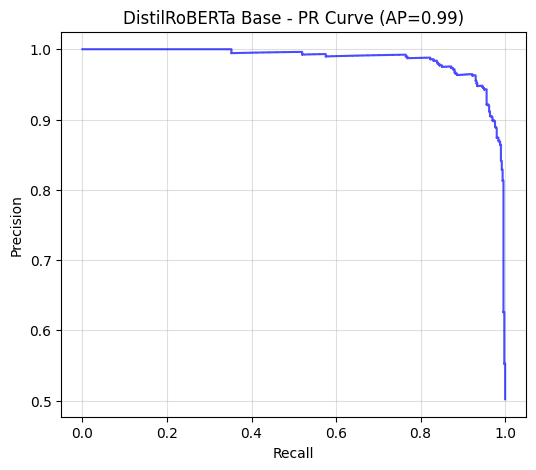

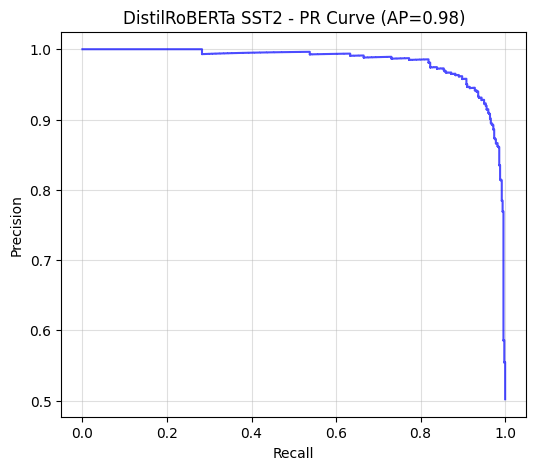

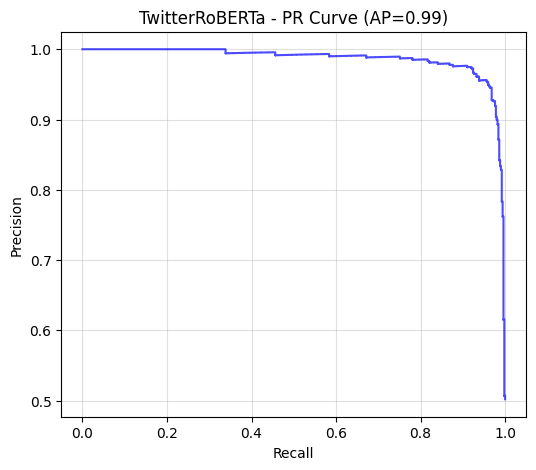

In [32]:
def plot_pr_curve(y_true, y_pred_prob, title):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    ap = average_precision_score(y_true, y_pred_prob)

    plt.figure(figsize=(6,5))
    plt.step(recall, precision, where='post', color='b', alpha=0.7)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{title} (AP={ap:.2f})')
    plt.grid(alpha=0.4)
    plt.show()

preds_base = trainer_distil_base.predict(small_test_dataset).predictions
preds_distil = trainer_distil_sst2.predict(small_test_dataset).predictions
preds_twitter = trainer_twitter.predict(small_test_dataset).predictions

y_prob_base = preds_base[:, 1]
y_prob_distil = preds_distil[:, 1]
y_prob_twitter = preds_twitter[:, 1]

plot_pr_curve(results_base["y_true"], y_prob_base, "DistilRoBERTa Base - PR Curve")
plot_pr_curve(results_distil["y_true"], y_prob_distil, "DistilRoBERTa SST2 - PR Curve")
plot_pr_curve(results_twitter["y_true"], y_prob_twitter, "TwitterRoBERTa - PR Curve")



In [29]:
df_results = pd.DataFrame([
    {"Model": "DistilRoBERTa Base", "Accuracy": results_base["accuracy"], "Precision": results_base["precision"], "Recall": results_base["recall"], "F1": results_base["f1"]},
    {"Model": "DistilRoBERTa SST2", "Accuracy": results_distil["accuracy"], "Precision": results_distil["precision"], "Recall": results_distil["recall"], "F1": results_distil["f1"]},
    {"Model": "TwitterRoBERTa", "Accuracy": results_twitter["accuracy"], "Precision": results_twitter["precision"], "Recall": results_twitter["recall"], "F1": results_twitter["f1"]}
])

print(df_results)


                Model  Accuracy  Precision  Recall        F1
0  DistilRoBERTa Base     0.942   0.942117   0.942  0.941998
1  DistilRoBERTa SST2     0.936   0.936006   0.936  0.935999
2      TwitterRoBERTa     0.956   0.956007   0.956  0.955999


In [30]:
df_results.to_csv("model_comparison.csv", index=False)